In [ ]:
import numpy as np
from numpy.typing import NDArray
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from typing import List, Tuple, Sequence

from type_definitions.test_case import TestCase
from type_definitions.test_result import TestResult
from type_definitions.utils import *

In [2]:
seed = 100
np.random.seed(seed)

cases = generate_cases(50)
results = evaluate_cases(cases)
trajectories = [r.trajectory for r in results if not r.simulation_failed]
valid_results = [r for r in results if not r.simulation_failed]

print(f"Generated {len(trajectories)} valid trajectories")
print(
    f"Crashed: {sum(1 for r in valid_results if r.crashed)}, Safe: {sum(1 for r in valid_results if not r.crashed)}"
)

Generated 37 valid trajectories
Crashed: 25, Safe: 12


In [ ]:
distance_matrix_file = f"cache/distance_matrix_seed{seed}_size{len(trajectories)}.npy"

if os.path.exists(distance_matrix_file):
    print(f"Loading distance matrix from {distance_matrix_file}")
    distance_matrix = np.load(distance_matrix_file)
else:
    print("Calculating pairwise distances...")
    distance_matrix = pairwise_distances(trajectories)
    np.save(distance_matrix_file, distance_matrix)
    print(f"Distance matrix saved to {distance_matrix_file}")

print(f"Distance matrix shape: {distance_matrix.shape}")
width, uniformity = frechet_coverage(distance_matrix)

print(f"Distance distribution width: {width:.4f}")
print(f"Distance distribution uniformity: {uniformity:.4f}")

iu0 = np.triu_indices(distance_matrix.shape[0], k=1)
d0 = distance_matrix[iu0]
fixed_bins = 40  # pick a constant (e.g., 30–60). Keep this fixed across cycles.
fixed_range = (float(d0.min()), float(d0.max()))

print(f"Fixed histogram: bins={fixed_bins}, range={fixed_range}")

Loading distance matrix from cache/distance_matrix_seed100_size37.npy
Fixed histogram: bins=40, range=(772.5375073970674, 17988.05286725169)
Distance matrix shape: (37, 37)
Distance distribution width: 12807.3172
Distance distribution uniformity: 0.9615


In [5]:
def testcase_to_ndarray(test_case: TestCase) -> np.ndarray:

    return np.array(
        [
            test_case.vt,
            test_case.alpha,
            test_case.beta,
            test_case.phi,
            test_case.theta,
            test_case.psi,
            test_case.alt,
            test_case.power,
        ]
    )


test_cases = [r.test_case for r in valid_results]
features = np.array([testcase_to_ndarray(case) for case in test_cases])
features.shape


def pair_features_between(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    feat_diff = a - b
    feat_abs_diff = np.abs(feat_diff)
    euclidean_dist = np.linalg.norm(feat_diff)
    angular_indices = [1, 2, 3, 4, 5]
    angular_diffs = []
    for idx in angular_indices:
        d = feat_diff[idx]
        while d > np.pi:
            d -= 2 * np.pi
        while d < -np.pi:
            d += 2 * np.pi
        angular_diffs.append(d)
    return np.concatenate([feat_diff, feat_abs_diff, [euclidean_dist], angular_diffs])


def ndarray_to_testcase(arr: Sequence[float]) -> TestCase:
    return TestCase(
        vt=float(arr[0]),
        alpha=float(arr[1]),
        beta=float(arr[2]),
        phi=float(arr[3]),
        theta=float(arr[4]),
        psi=float(arr[5]),
        alt=float(arr[6]),
        power=float(arr[7]),
    )

In [6]:
def create_pairwise_features(
    features: NDArray[np.float64], distance_matrix: NDArray[np.float64]
) -> Tuple[NDArray[np.float64], NDArray[np.float64]]:
    n = features.shape[0]
    pairwise_features = []
    distances = []

    # Use upper triangular matrix to avoid duplicates
    for i in range(n):
        for j in range(i + 1, n):
            # Feature differences
            feat_diff = features[i] - features[j]
            feat_abs_diff = np.abs(feat_diff)

            # Additional features
            euclidean_dist = np.linalg.norm(feat_diff)

            # Angular differences for angles (alpha, beta, phi, theta, psi)
            angular_indices = [1, 2, 3, 4, 5]  # alpha, beta, phi, theta, psi
            angular_diffs = []
            for idx in angular_indices:
                diff = feat_diff[idx]
                # Normalize to [-pi, pi]
                while diff > np.pi:
                    diff -= 2 * np.pi
                while diff < -np.pi:
                    diff += 2 * np.pi
                angular_diffs.append(diff)

            # Combine all features
            combined_features = np.concatenate(
                [
                    feat_diff,
                    feat_abs_diff,
                    [euclidean_dist],
                    angular_diffs,
                ]
            )

            pairwise_features.append(combined_features)
            distances.append(distance_matrix[i, j])

    return np.array(pairwise_features), np.array(distances)


X, y = create_pairwise_features(features, distance_matrix)

print(f"Pairwise features shape: {X.shape}")
print(f"Distances shape: {y.shape}")

Pairwise features shape: (666, 22)
Distances shape: (666,)


In [7]:
# Helper methods


def sample_test_cases_with_rf(
    rf_model: RandomForestRegressor,
    scaler: StandardScaler,
    base_features: np.ndarray,
    n_select: int = 20,
    n_candidates: int = 2000,
    seed: int = 100,
    include_selected_in_pool: bool = True,
) -> list[TestCase]:
    rng = np.random.default_rng(seed)
    feat_min = base_features.min(axis=0)
    feat_max = base_features.max(axis=0)
    candidates = rng.uniform(
        low=feat_min, high=feat_max, size=(n_candidates, base_features.shape[1])
    )
    pool = base_features.copy()
    selected = []

    for _ in range(n_select):
        pool_sub = pool
        min_pred = np.full(n_candidates, np.inf, dtype=float)
        batch_size = 512
        for start in range(0, len(pool_sub), batch_size):
            end = min(start + batch_size, len(pool_sub))
            batch = pool_sub[start:end]

            pairs = []
            for b in batch:
                diffs = candidates - b
                abs_diffs = np.abs(diffs)
                eucl = np.linalg.norm(diffs, axis=1, keepdims=True)
                ang_idx = [1, 2, 3, 4, 5]
                ang_diffs = []
                for idx in ang_idx:
                    d = diffs[:, idx].copy()
                    d = (d + np.pi) % (2 * np.pi) - np.pi
                    ang_diffs.append(d.reshape(-1, 1))
                ang_diffs = np.hstack(ang_diffs)
                pair_block = np.hstack([diffs, abs_diffs, eucl, ang_diffs])
                pairs.append(pair_block)

            pairmat = np.vstack(pairs)
            pairmat_scaled = scaler.transform(pairmat)
            preds = rf_model.predict(pairmat_scaled).reshape(-1)
            preds_reshaped = preds.reshape(len(batch), n_candidates)
            batch_min = preds_reshaped.min(axis=0)
            min_pred = np.minimum(min_pred, batch_min)

        best_idx = int(np.argmax(min_pred))
        best = candidates[best_idx]
        selected.append(best)
        if include_selected_in_pool:
            pool = np.vstack([pool, best[None, :]])
        candidates[best_idx] = rng.uniform(
            low=feat_min, high=feat_max, size=(base_features.shape[1],)
        )

    return [ndarray_to_testcase(s) for s in selected]


def run_active_coverage_cycles(
    init_cases: list[TestCase],
    cycles: int = 5,
    per_cycle_new: int = 20,
    n_candidates: int = 2000,
    seed: int = 100,
    cache_distances: bool = True,
):
    rng = np.random.default_rng(seed)
    results_all = evaluate_cases(init_cases)
    trajectories = [r.trajectory for r in results_all if not r.simulation_failed]
    test_cases = [r.test_case for r in results_all if not r.simulation_failed]
    features = np.array([testcase_to_ndarray(tc) for tc in test_cases])

    for c in range(1, cycles + 1):
        distance_matrix_file = (
            f"cache/distance_matrix_seed{seed}_size{len(trajectories)}.npy"
        )
        if cache_distances and os.path.exists(distance_matrix_file):
            distance_matrix = np.load(distance_matrix_file)
        else:
            distance_matrix = pairwise_distances(trajectories)
            if cache_distances:
                np.save(distance_matrix_file, distance_matrix)

        width, uniformity = frechet_coverage(distance_matrix)
        print(
            f"[Cycle {c}] N={len(trajectories)} width={width:.2f} uniformity={uniformity:.4f}"
        )

        X, y = create_pairwise_features(features, distance_matrix)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=seed
        )
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        rf_model = RandomForestRegressor(
            n_estimators=100, max_depth=20, random_state=seed, n_jobs=-1
        )
        rf_model.fit(X_train_scaled, y_train)

        new_cases = sample_test_cases_with_rf(
            rf_model=rf_model,
            scaler=scaler,
            base_features=features,
            n_select=per_cycle_new,
            n_candidates=n_candidates,
            seed=int(rng.integers(0, 1_000_000)),
            include_selected_in_pool=True,
        )

        new_results = evaluate_cases(new_cases)
        new_valid = [r for r in new_results if not r.simulation_failed]
        new_trajs = [r.trajectory for r in new_valid]
        new_feats = np.array([testcase_to_ndarray(r.test_case) for r in new_valid])

        if len(new_trajs) == 0:
            print(f"[Cycle {c}] No valid new trajectories; stopping.")
            break

        results_all.extend(new_valid)
        trajectories.extend(new_trajs)
        features = np.vstack([features, new_feats])

    distance_matrix = pairwise_distances(trajectories)
    width, uniformity = frechet_coverage(distance_matrix)
    print(
        f"[Final] N={len(trajectories)} width={width:.2f} uniformity={uniformity:.4f}"
    )
    return results_all, trajectories, features

In [8]:
# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training set: 532 samples
Test set: 134 samples


In [9]:
initial_cases = [r.test_case for r in valid_results]

results_all, trajectories_all, features_all = run_active_coverage_cycles(
    init_cases=initial_cases,
    cycles=2,
    per_cycle_new=20,
    n_candidates=2000,
    seed=seed,
    cache_distances=True,
)

TypeError: frechet_coverage() missing 2 required positional arguments: 'bins' and 'hist_range'

In [ ]:
# Train Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=100, max_depth=20, random_state=seed, n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
# Make predictions
rf_predictions = rf_model.predict(X_test_scaled)

rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_r2 = rf_model.score(X_test_scaled, y_test)


print(f"MAE: {rf_mae:.2f}")
print(f"RMSE: {rf_rmse:.2f}")
print(f"R squared: {rf_r2:.4f}")

MAE: 2513.35
RMSE: 3162.48
R squared: 0.1310


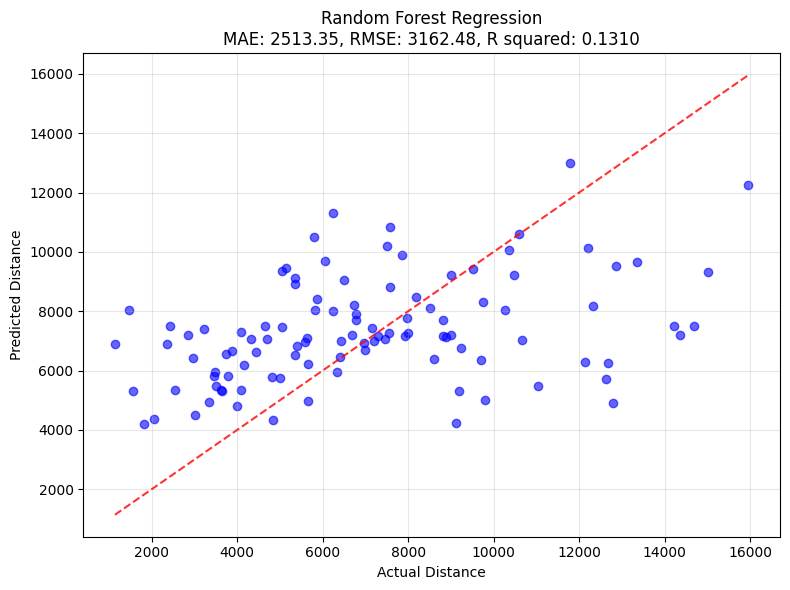

In [ ]:
# Visualize results
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.scatter(y_test, rf_predictions, alpha=0.6, color="blue")
min_val = min(y_test.min(), rf_predictions.min())
max_val = max(y_test.max(), rf_predictions.max())
ax.plot([min_val, max_val], [min_val, max_val], "r--", alpha=0.8)
ax.set_xlabel("Actual Distance")
ax.set_ylabel("Predicted Distance")
ax.set_title(
    f"Random Forest Regression\nMAE: {rf_mae:.2f}, RMSE: {rf_rmse:.2f}, R squared: {rf_r2:.4f}"
)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Feature importance analysis
feature_names = [
    "vt_diff",
    "alpha_diff",
    "beta_diff",
    "phi_diff",
    "theta_diff",
    "psi_diff",
    "alt_diff",
    "power_diff",
    "vt_abs_diff",
    "alpha_abs_diff",
    "beta_abs_diff",
    "phi_abs_diff",
    "theta_abs_diff",
    "psi_abs_diff",
    "alt_abs_diff",
    "power_abs_diff",
    "euclidean_dist",
    "alpha_angular_diff",
    "beta_angular_diff",
    "phi_angular_diff",
    "theta_angular_diff",
    "psi_angular_diff",
]

# Get feature importances
rf_importances = rf_model.feature_importances_

# Sort features by importance
rf_indices = np.argsort(rf_importances)[::-1]

print("Top 10 Most Important Features:")
for i in range(min(10, len(feature_names))):
    idx = rf_indices[i]
    print(f"  {i+1}. {feature_names[idx]}: {rf_importances[idx]:.4f}")

Top 10 Most Important Features:
  1. phi_diff: 0.1629
  2. vt_abs_diff: 0.0947
  3. phi_abs_diff: 0.0866
  4. phi_angular_diff: 0.0611
  5. theta_diff: 0.0578
  6. vt_diff: 0.0561
  7. beta_abs_diff: 0.0553
  8. theta_abs_diff: 0.0512
  9. alt_diff: 0.0500
  10. alpha_angular_diff: 0.0496
